In [151]:
import numpy as np
import math 
import pprint
from marchMadnessBracket.utils import *
from marchMadnessBracket.Team import Team
from marchMadnessBracket.Bracket import Bracket
from marchMadnessBracket.torch_bracket import TorchBracket
import pickle
from marchMadnessBracket.data.bracket_2021 import teams, human_picks

In [152]:
with open('trained_bracket.pkl', 'rb') as f:
    mc_human = pickle.load(f)

In [153]:
simulation_bracket = Bracket.from_array(teams,{"sim_method":realistic_game_logisitic})

In [154]:
evo_brackets = [Bracket.from_array(teams) for _ in range(50)]
for evo_bracket in evo_brackets:
    evo_bracket.random_flip(p_flip=.5)
evo_brackets = np.array(evo_brackets)

In [155]:
simulation_bracket = Bracket.from_array(teams,{"sim_method":realistic_game_logisitic})

In [156]:
def human_round(n_humans,round_winners):
    return np.array([mc_human.score(round_winners) for _ in range(n_humans)])

In [157]:
def evo_round(evo_brackets,round_winners):
    return np.array([evo_bracket.score(round_winners) for evo_bracket in evo_brackets])

In [158]:
n_humans = 20

In [159]:
def one_round(evo_brackets):
    round_winners = simulation_bracket.round_winners()
    human_scores = human_round(n_humans,round_winners)
    score_to_beat = np.max(human_scores)
    evo_scores = evo_round(evo_brackets,round_winners)
    would_win = evo_scores > score_to_beat
    return would_win

In [160]:
def many_rounds(n_rounds,evo_brackets):
    round_results = [one_round(evo_brackets) for _ in range(n_rounds)]
    return np.sum(round_results,axis=0)

In [161]:
def select_winers_losers(evo_brackets,round_results):
    evo_results = list(zip(evo_brackets,round_results))
    evo_results = sorted(evo_results,key = lambda x: -x[1])
    evo_brackets,round_results = zip(*evo_results)
    n_brackets = len(evo_brackets)
    cut = int(n_brackets/(3))
    winners = evo_brackets[:-cut]
    losers = evo_brackets[-cut:]
    return winners, losers

In [162]:
def random_teams(temp_list):
    len_list = len(temp_list)
    rand1,rand2 = np.random.randint(0,len_list-1,size=2)
    return temp_list[rand1],temp_list[rand2]

In [163]:
def combine_list(l1,l2):
    assert len(l1) == len(l2), "lists must be same length"
    length = len(l1)
    rand_arr = np.random.rand(length)
    combined_list = [l1_el if r>.5 else l2_el  for r,l1_el, l2_el in zip(rand_arr,l1,l2)]
    return np.array(combined_list)

In [164]:
def update_losers(loser_list, winner_list):
    for loser in loser_list:
        w1,w2 =  random_teams(winner_list)
        w1_arr, w2_arr = w1.win_loss_array, w2.win_loss_array
        wl_arr = combine_list(w1_arr, w2_arr)
        loser.win_loss_array = wl_arr
        loser.random_flip(p_flip=.03)

In [165]:
def one_epoch(evo_brackets):
    round_results = many_rounds(100,evo_brackets)
    
    for r,ev in zip(round_results,evo_brackets):
        ev.wins+= r
        ev.itr += 1

    winners, losers = select_winers_losers(evo_brackets,round_results)
    for los in losers:
        los.wins = 0
        los.itr = 0
        
    print("--------")
    update_losers(losers, winners)
    evo_brackets = np.concatenate((winners ,losers))
    return evo_brackets, round_results

In [ ]:
results = []
scores = []

In [187]:
from scipy.optimize import curve_fit

def logisitc(x,offset,scale,norm):
    return norm/(1+(2*2.7)**(-(x-offset)/scale))

--------
wins: 12.86 scores: 79.98


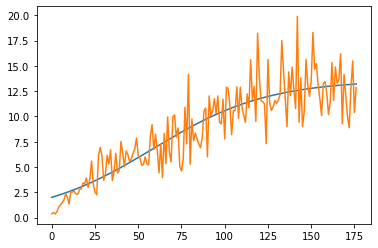

--------
wins: 10.12 scores: 93.78


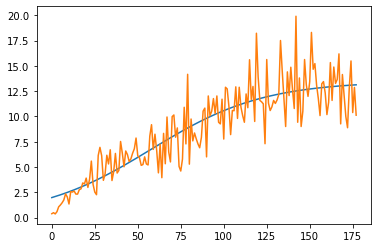

--------
wins: 8.64 scores: 61.1


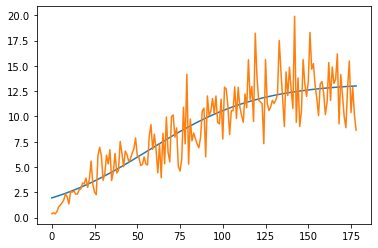

--------
wins: 13.98 scores: 62.48


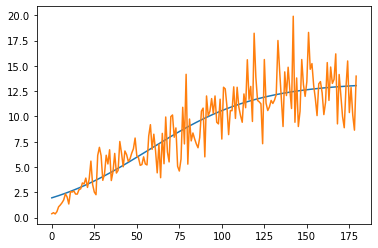

--------
wins: 12.96 scores: 86.62


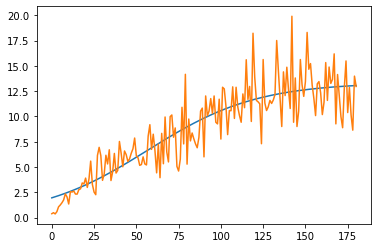

--------
wins: 9.52 scores: 60.7


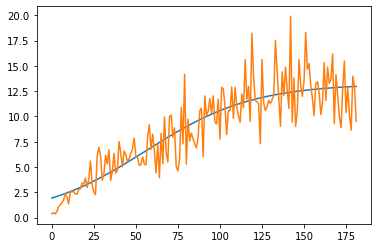

--------
wins: 10.28 scores: 55.14


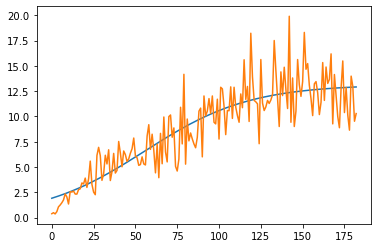

--------
wins: 10.94 scores: 96.56


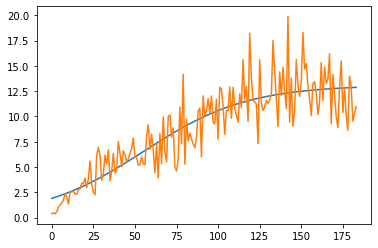

--------
wins: 11.3 scores: 118.6


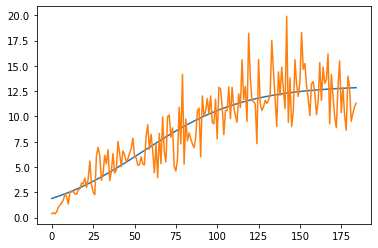

--------
wins: 15.14 scores: 63.04


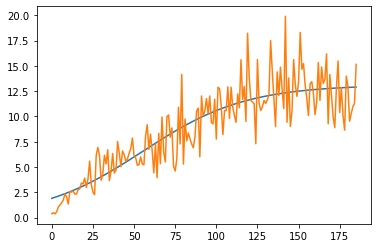

--------
wins: 15.8 scores: 61.5


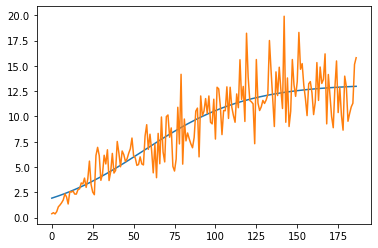

--------
wins: 12.92 scores: 80.64


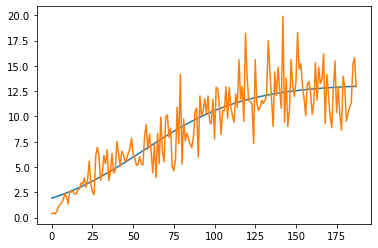

--------
wins: 10.42 scores: 75.52


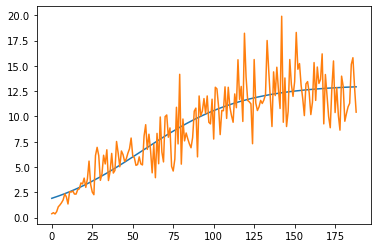

--------
wins: 17.2 scores: 72.06


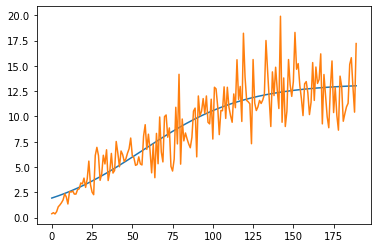

--------
wins: 15.68 scores: 86.64


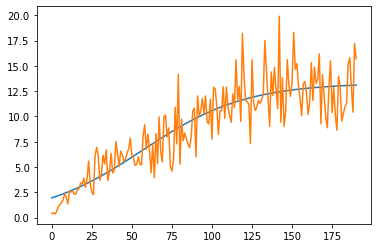

--------
wins: 13.94 scores: 123.8


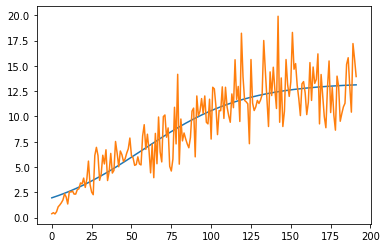

--------
wins: 8.66 scores: 67.46


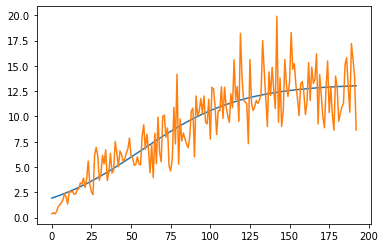

--------
wins: 12.4 scores: 80.16


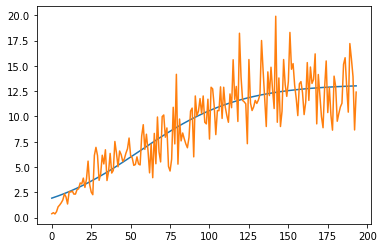

--------
wins: 12.42 scores: 72.34


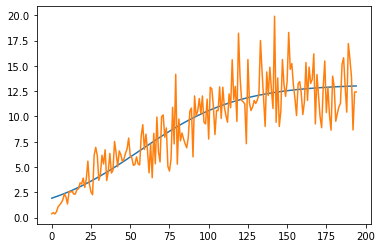

--------
wins: 18.62 scores: 136.76


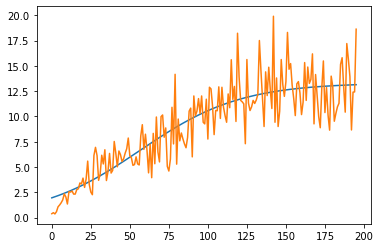

--------
wins: 19.8 scores: 94.68


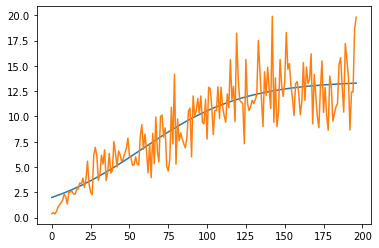

--------
wins: 13.04 scores: 95.2


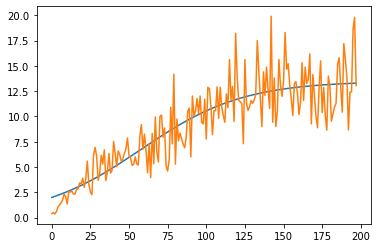

--------
wins: 16.72 scores: 53.42


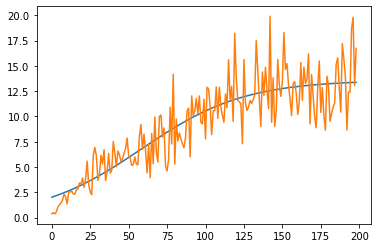

--------
wins: 10.58 scores: 77.08


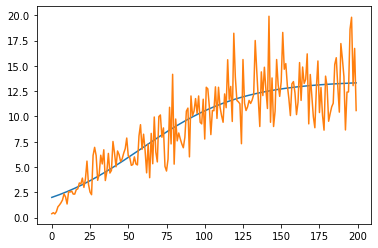

--------
wins: 13.3 scores: 84.4


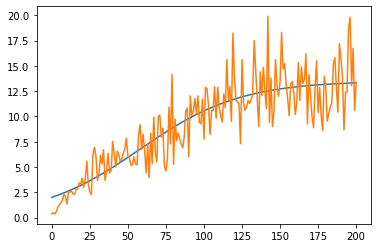

--------
wins: 19.2 scores: 84.88


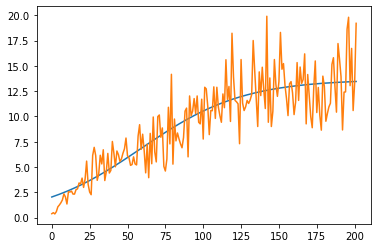

--------
wins: 15.48 scores: 61.62


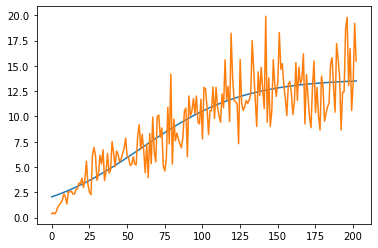

--------
wins: 14.36 scores: 56.78


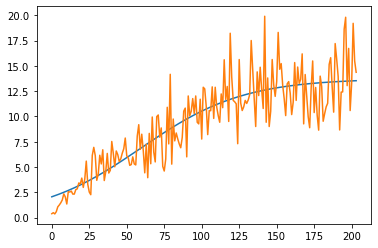

--------
wins: 13.5 scores: 104.04


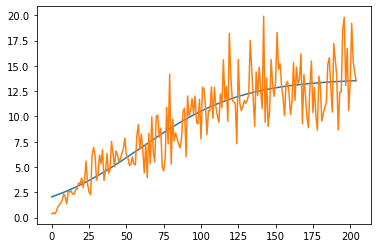

--------
wins: 18.52 scores: 128.8


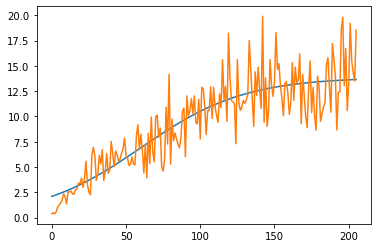

--------
wins: 13.34 scores: 113.9


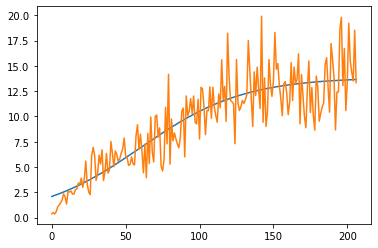

--------
wins: 16.18 scores: 59.46


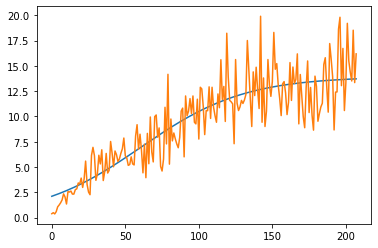

--------
wins: 11.8 scores: 99.06


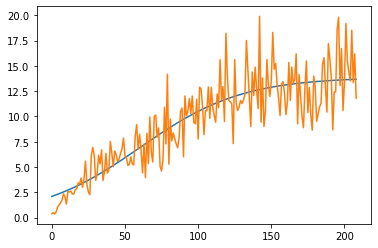

--------
wins: 12.24 scores: 66.8


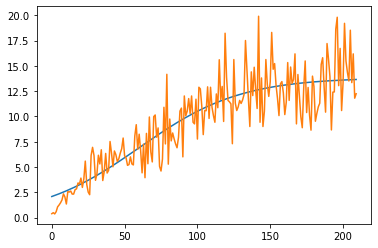

--------
wins: 15.34 scores: 50.18


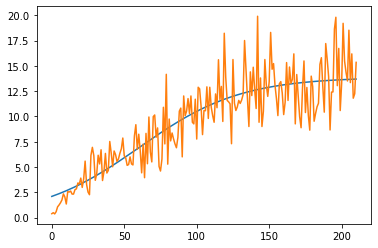

--------
wins: 15.78 scores: 92.12


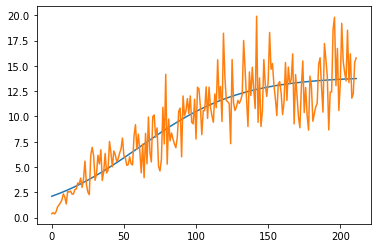

--------
wins: 17.82 scores: 76.12


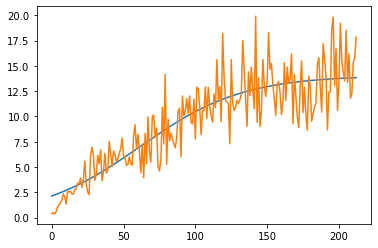

--------
wins: 16.46 scores: 91.8


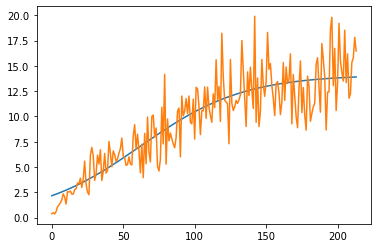

--------
wins: 11.62 scores: 44.18


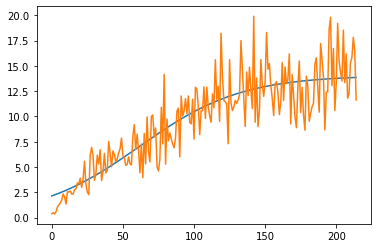

--------
wins: 14.74 scores: 103.88


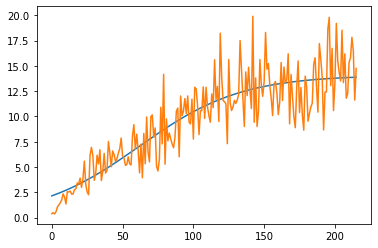

--------
wins: 10.46 scores: 107.24


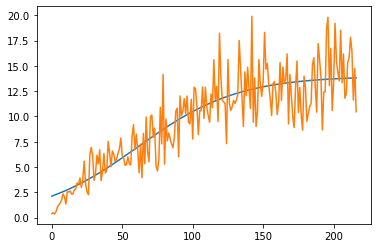

--------
wins: 13.78 scores: 56.88


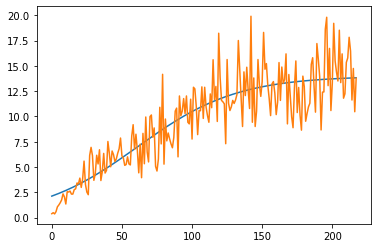

--------
wins: 15.68 scores: 108.02


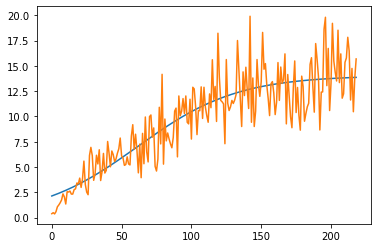

--------
wins: 15.7 scores: 110.36


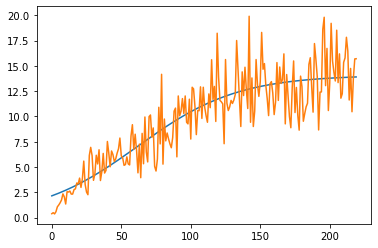

--------
wins: 13.5 scores: 75.12


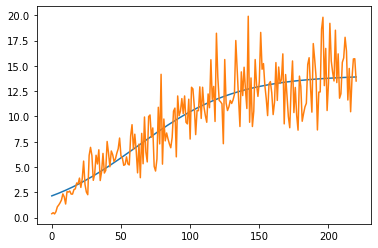

--------
wins: 19.16 scores: 85.02


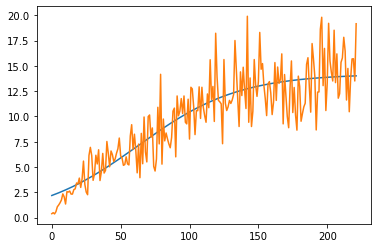

--------
wins: 11.22 scores: 73.02


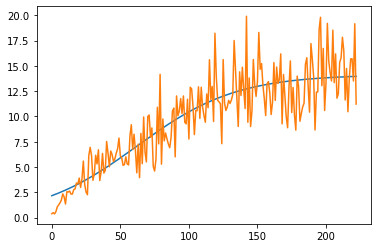

--------
wins: 15.78 scores: 97.1


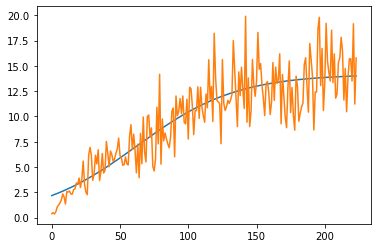

--------
wins: 15.54 scores: 109.26


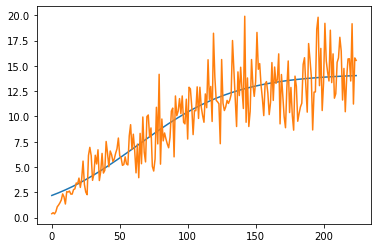

--------
wins: 10.28 scores: 60.04


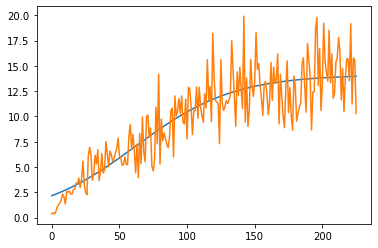

--------
wins: 21.22 scores: 126.24


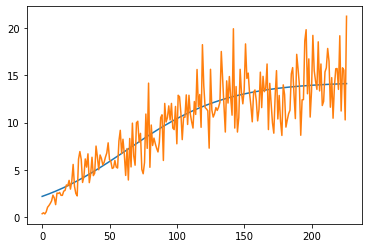

--------
wins: 14.16 scores: 75.08


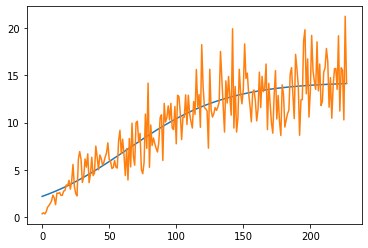

--------
wins: 17.4 scores: 66.96


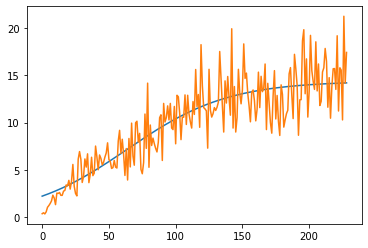

--------
wins: 16.62 scores: 60.46


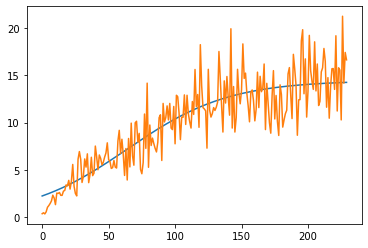

--------
wins: 12.68 scores: 109.66


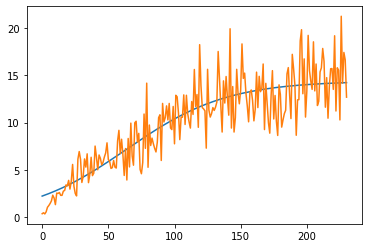

--------
wins: 8.92 scores: 80.22


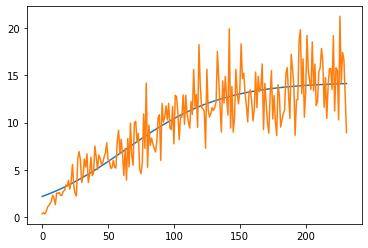

--------
wins: 12.02 scores: 101.84


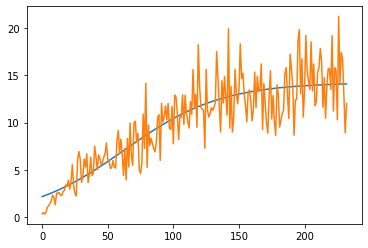

--------
wins: 15.06 scores: 80.64


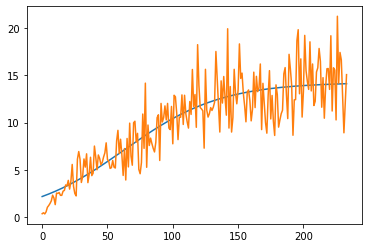

--------
wins: 14.82 scores: 128.14


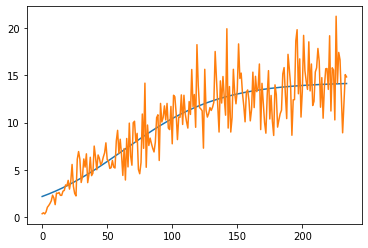

--------
wins: 15.62 scores: 87.12


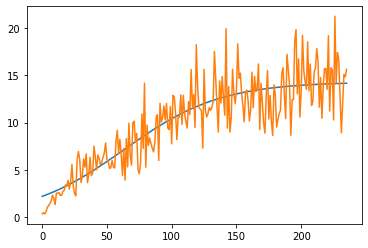

--------
wins: 17.26 scores: 113.2


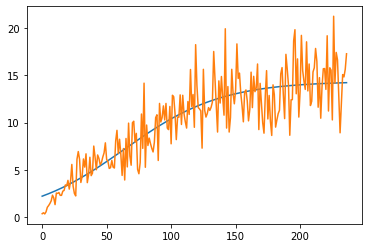

--------
wins: 11.42 scores: 82.48


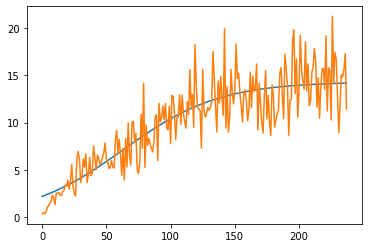

--------
wins: 14.88 scores: 94.54


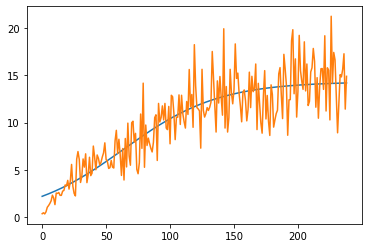

--------
wins: 12.38 scores: 73.54


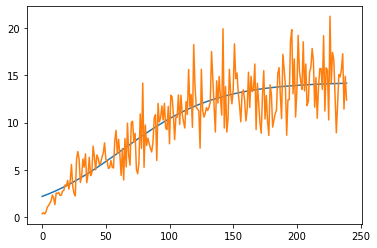

--------
wins: 15.16 scores: 113.58


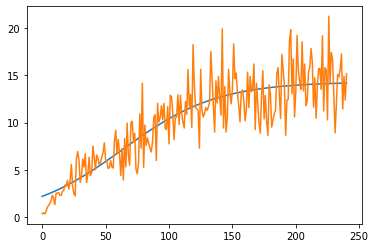

--------
wins: 12.16 scores: 57.56


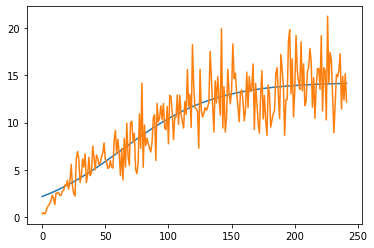

--------
wins: 17.32 scores: 78.8


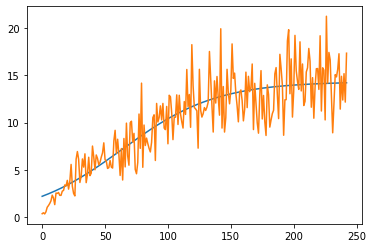

--------
wins: 14.22 scores: 110.74


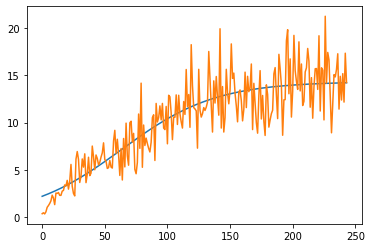

--------
wins: 17.68 scores: 74.74


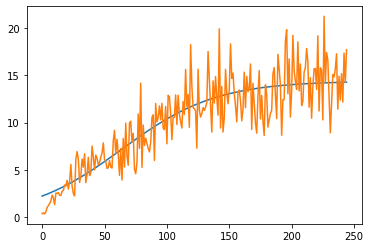

--------
wins: 12.48 scores: 61.3


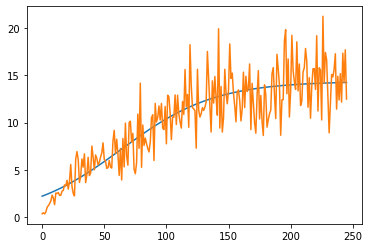

--------
wins: 10.02 scores: 70.98


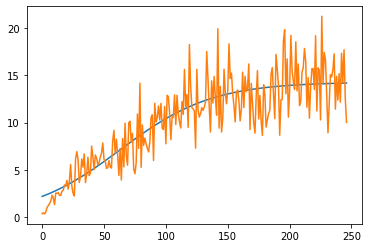

--------
wins: 11.44 scores: 93.98


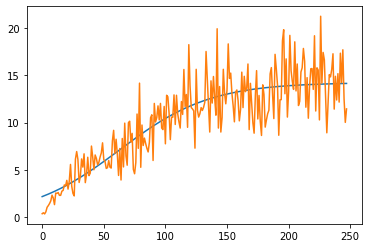

--------
wins: 16.6 scores: 67.88


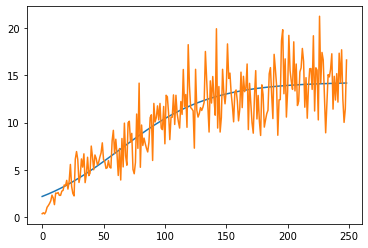

--------
wins: 16.06 scores: 127.3


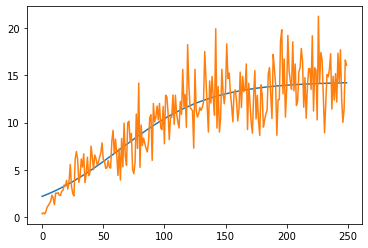

--------
wins: 12.74 scores: 146.26


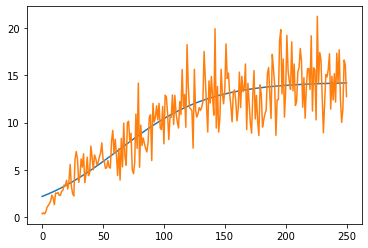

--------
wins: 14.48 scores: 96.16


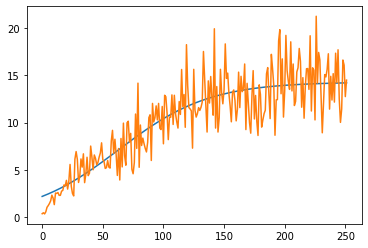

--------
wins: 11.6 scores: 112.14


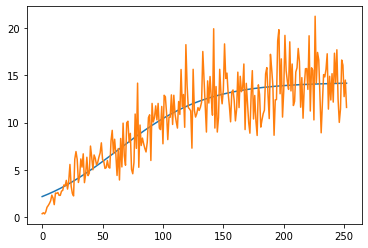

--------
wins: 8.76 scores: 97.44


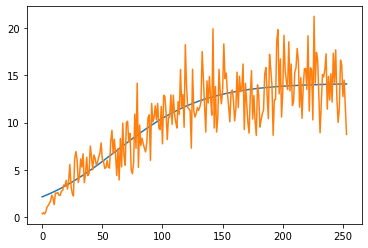

--------
wins: 10.48 scores: 123.08


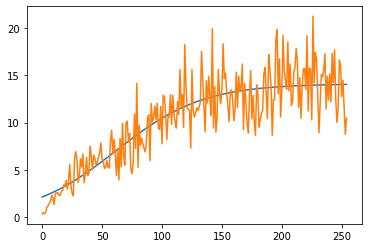

--------
wins: 15.86 scores: 53.42


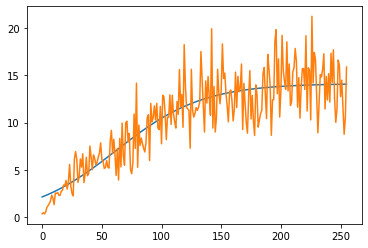

--------
wins: 9.96 scores: 75.86


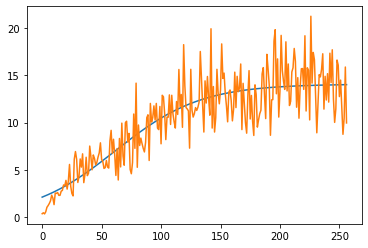

--------
wins: 15.32 scores: 72.94


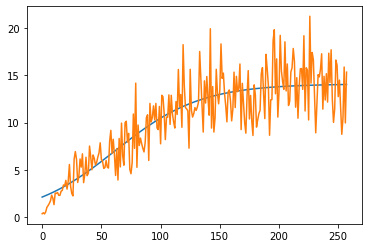

--------
wins: 13.12 scores: 72.9


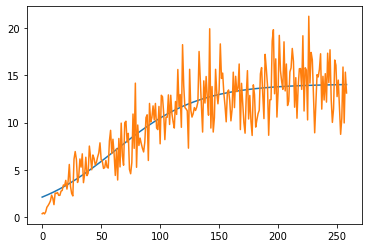

--------
wins: 15.58 scores: 73.96


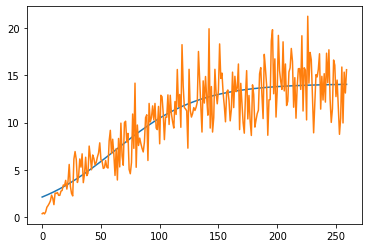

--------
wins: 17.82 scores: 84.54


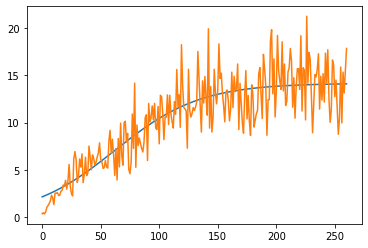

--------
wins: 14.3 scores: 75.48


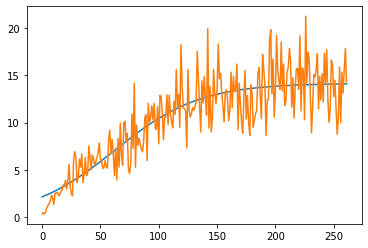

--------
wins: 9.9 scores: 66.66


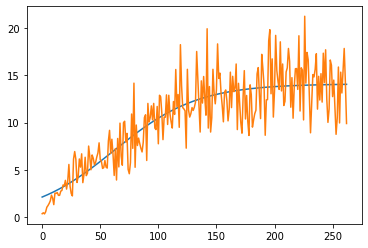

--------
wins: 12.18 scores: 90.16


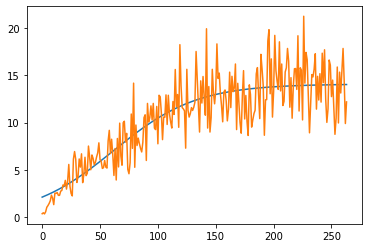

--------
wins: 10.66 scores: 51.98


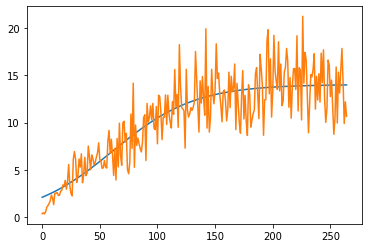

--------
wins: 12.94 scores: 103.44


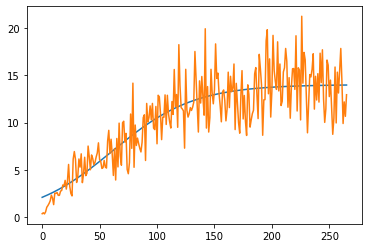

--------
wins: 11.68 scores: 83.32


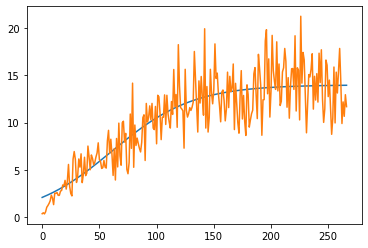

--------
wins: 17.68 scores: 142.54


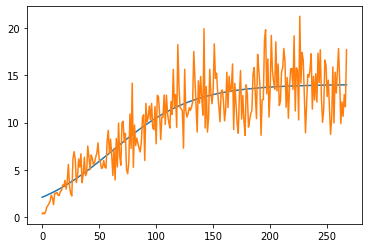

--------
wins: 16.88 scores: 59.28


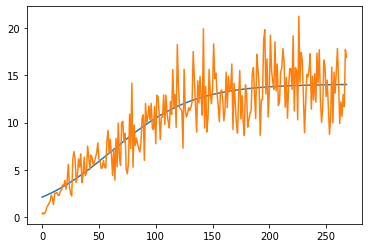

--------
wins: 10.96 scores: 53.58


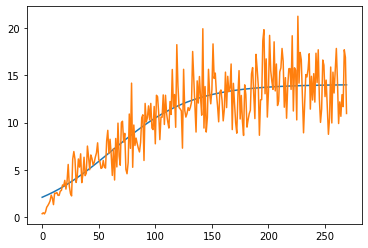

--------
wins: 10.62 scores: 80.82


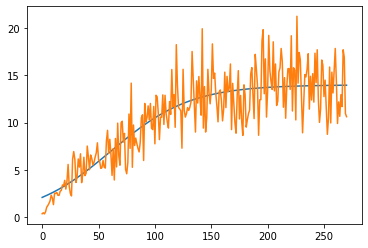

--------
wins: 12.72 scores: 41.38


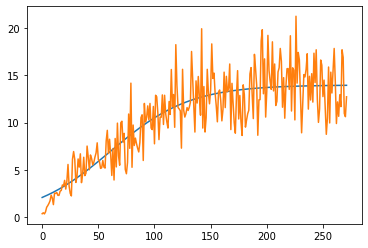

--------
wins: 12.06 scores: 45.26


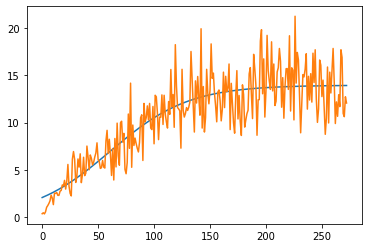

--------
wins: 17.8 scores: 86.62


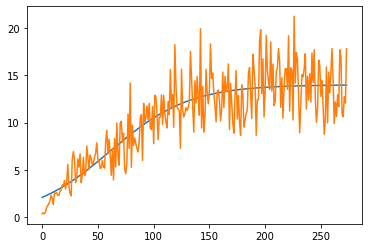

--------
wins: 11.08 scores: 105.5


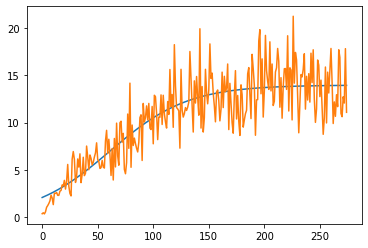

--------
wins: 21.8 scores: 75.02


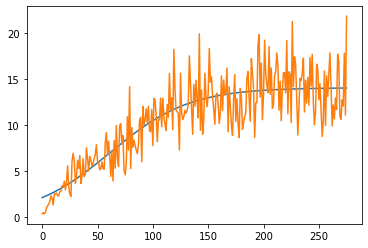

In [188]:
for ev in evo_brackets:
    ev.wins = 0
    ev.itr = 0
    
for i in range(100):
    evo_brackets, round_results = one_epoch(evo_brackets)
    avg_wins = np.mean(round_results)
    avg_score = np.mean([x.scores for x in evo_brackets])
    results.append(avg_wins)
    scores.append(avg_score)
    print("wins: {} scores: {}".format(avg_wins,avg_score))

    plt.clf()
    x = np.array([i for i in range(len(results))])
    popt, pcov = curve_fit(logisitc, x, results)
    y = logisitc(x,*popt)
    plt.plot(y)
    plt.plot(results)
    plt.show()

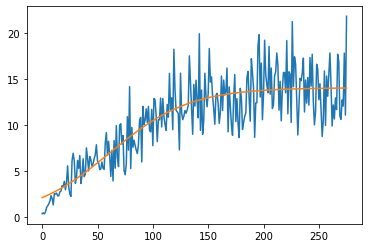

array([61.53380972, 60.20068708, 14.04843048])

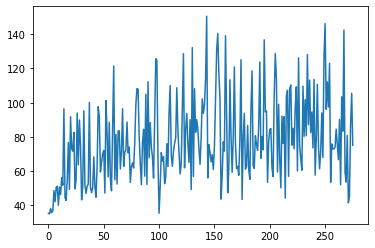

In [189]:
import matplotlib.pyplot as plt
plt.plot(results)
x = np.array([i for i in range(len(results))])
popt, pcov = curve_fit(logisitc, x, results)
y = logisitc(x,*popt)
plt.plot(y)
plt.show()
plt.clf()
plt.plot(scores)
popt

In [190]:
evo_brackets_en = enumerate(evo_brackets)
for i, ev in sorted(evo_brackets_en,key=lambda ev: -ev[1].wins/(ev[1].itr+.1)):
    print(i,ev.wins/(ev.itr+.1),ev.itr)

28 22.727272727272727 1
33 20.909090909090907 1
29 18.387096774193548 3
32 17.741935483870968 3
7 17.619047619047617 2
8 17.619047619047617 2
31 17.142857142857142 2
30 16.07843137254902 5
5 16.043956043956044 9
9 15.934065934065934 9
3 15.675675675675675 11
4 15.352112676056338 7
18 15.246690734055356 83
1 15.206611570247935 12
19 15.206391478029296 75
17 15.175936435868332 88
15 15.173961840628508 89
16 15.173961840628508 89
2 15.124378109452735 20
6 15.114503816793894 13
20 15.065123010130247 69
21 14.992076069730587 63
10 14.895104895104897 100
11 14.895104895104897 100
12 14.895104895104897 100
13 14.895104895104897 100
14 14.895104895104897 100
27 14.87603305785124 12
22 14.84560570071259 42
23 14.84560570071259 42
0 14.7682119205298 15
24 14.698162729658792 38
25 14.570446735395189 29
26 14.570446735395189 29
34 0.0 0
35 0.0 0
36 0.0 0
37 0.0 0
38 0.0 0
39 0.0 0
40 0.0 0
41 0.0 0
42 0.0 0
43 0.0 0
44 0.0 0
45 0.0 0
46 0.0 0
47 0.0 0
48 0.0 0
49 0.0 0


In [198]:
evo_brackets[17].round_winners()

[['Gonzaga',
  'Missouri',
  'Creighton',
  'Virginia',
  'USC',
  'Kansas',
  'Oregon',
  'Iowa',
  'Michigan',
  'St. Bonaventure',
  'Colorado',
  'Florida St.',
  'BYU',
  'Texas',
  'Connecticut',
  'Alabama',
  'Baylor',
  'Wisconsin',
  'Villanova',
  'Purdue',
  'Texas Tech',
  'Arkansas',
  'Virginia Tech',
  'Ohio St.',
  'Illinois',
  'Georgia Tech',
  'Tennessee',
  'Oklahoma St.',
  'SDSU',
  'West Virginia',
  'Rutgers',
  'Houston'],
 ['Gonzaga',
  'Creighton',
  'Kansas',
  'Iowa',
  'Michigan',
  'Florida St.',
  'Texas',
  'Alabama',
  'Baylor',
  'Villanova',
  'Texas Tech',
  'Ohio St.',
  'Illinois',
  'Tennessee',
  'West Virginia',
  'Houston'],
 ['Gonzaga',
  'Iowa',
  'Michigan',
  'Alabama',
  'Baylor',
  'Ohio St.',
  'Illinois',
  'Houston'],
 ['Iowa', 'Michigan', 'Baylor', 'Houston'],
 ['Iowa', 'Baylor'],
 ['Baylor']]

In [196]:
evo_brackets[17].win_loss_array

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [197]:
evo_brackets[18].win_loss_array

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])